# Offline Plotting Tutorial

The dataset comes with a tool for offline (i.e. not live as the data are coming in) plotting. This notebook explains how to use it and what it is capable of plotting. **NOTE**: This notebook only covers the plotting of numerical data. For categorical (string-valued) data, please see [Offline plotting with categorical data](Offline%20plotting%20with%20categorical%20data.ipynb).

The function that is going to be used in this tutorial is the `plot_dataset`. For convenience it is also possible to directly plot the dataset from the `captured_run_id`. Apart from the first argument `plot_by_id` behaves exactly like the `plot_dataset`. All customizations shown below can also be applied to `plot_by_id`.

In [1]:
%matplotlib inline
from pathlib import Path

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from qcodes.dataset import (
    Measurement,
    initialise_or_create_database_at,
    load_or_create_experiment,
    plot_dataset,
)
from qcodes.parameters import Parameter

Logging hadn't been started.
Activating auto-logging. Current session state plus future input saved.
Filename       : /home/runner/.qcodes/logs/command_history.log
Mode           : append
Output logging : True
Raw input log  : False
Timestamping   : True
State          : active


Qcodes Logfile : /home/runner/.qcodes/logs/240704-14963-qcodes.log


Let us first initialise our database and create an experiment which shall produce the data to be visualise.

In [2]:
initialise_or_create_database_at(Path.cwd() / "offline_plotting_example.db")
exp = load_or_create_experiment('offline_plotting_experiment', 'nosample')

Next we make a handful of parameters to be used in the examples of this notebook.

For those curious, setting `set_cmd=None` and `get_cmd=None` makes the `Parameters` settable and gettable without them being hooked up to any external/auxiliary action (in old QCoDeS versions, this was known as a `ManualParameter`).

In [3]:
# Make a handful of parameters to be used in the examples

x = Parameter(name='x', label='Voltage', unit='V',
              set_cmd=None, get_cmd=None)
t = Parameter(name='t', label='Time', unit='s',
              set_cmd=None, get_cmd=None)
y = Parameter(name='y', label='Voltage', unit='V',
              set_cmd=None, get_cmd=None)
y2 = Parameter(name='y2', label='Current', unit='A',
               set_cmd=None, get_cmd=None)
z = Parameter(name='z', label='Majorana number', unit='Anyonic charge',
              set_cmd=None, get_cmd=None)

## A single, simple 1D sweep

For the sake of simplicity, let us perform a single, 1D sweep:

In [4]:
meas = Measurement(exp=exp)
meas.register_parameter(x)
meas.register_parameter(y, setpoints=(x,))

xvals = np.linspace(-3.4, 4.2, 250)

# Randomly shuffle the values in order to test the plot
# that is to be created for this data is a correct line
# that does not depend on the order of the data.
np.random.shuffle(xvals)

with meas.run() as datasaver:
    for xnum in xvals:
        noise = np.random.randn()*0.1  # multiplicative noise yeah yeah
        datasaver.add_result((x, xnum),
                             (y, 2*(xnum+noise)**3 - 5*(xnum+noise)**2))

dataid = datasaver.run_id
dataset = datasaver.dataset

Starting experimental run with id: 1. 


Now let us plot that run. The function `plot_dataset` takes the `dataset` created by the run to plot as a positional argument. Furthermore, the user may specify the `matplotlib` axis object (or list of axis objects) to plot on.

If no axes are specified, the function creates new axis object(s). The function returns a tuple of a list of the axes and a list of the colorbar axes (just `None`s if there are no colorbars).

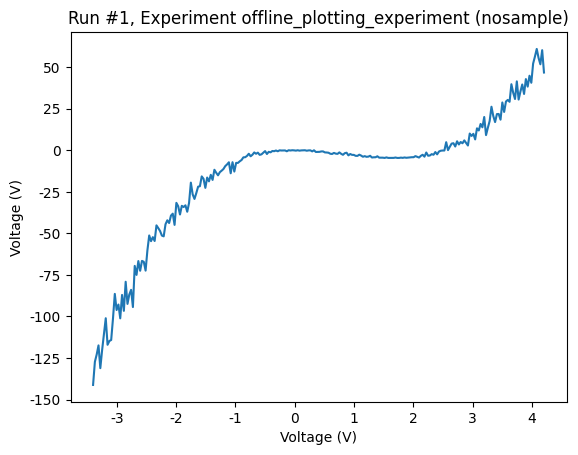

In [5]:
axes, cbaxes = plot_dataset(dataset)

Using the returned axis, we can change, among other things, the plot linewidth and color. We refer to the `matplotlib` documentation for details on `matplotlib` plot customization.

In [6]:
my_ax = axes[0]
line = my_ax.lines[0]
line.set_color('#223344')
line.set_linewidth(3)

### Rescaling units and ticks

The `plot_dataset` function can conveniently rescale the units and ticks of the plot. For example, if one of the axes is voltage in units of `V`, but the values are in the range of millivolts, then `plot_dataset` will rescale the ticks of the axis to show `5` instead of `0.005`, and the unit in the axis label will be adjusted from `V` to `mV`.

This feature works with the relevant SI units, and some others. In case the units of the parameter are not from that list, or are simply not specified, ticks and labels are left intact.

The feature can be explicitly turned off by passing `rescale_axes=False` to the function.

The following plot demontrates the feature.

In [7]:
meas = Measurement(exp=exp)
meas.register_parameter(t)
meas.register_parameter(y, setpoints=(t,))

with meas.run() as datasaver:
    for tnum in np.linspace(-3.4, 4.2, 50):
        noise = np.random.randn()*0.1
        datasaver.add_result((t, tnum*1e-6),
                             (y, (2*(tnum+noise)**3 - 5*(tnum+noise)**2)*1e3))

dataset = datasaver.dataset

Starting experimental run with id: 2. 


([<Axes: title={'center': 'Run #2, Experiment offline_plotting_experiment (nosample)'}, xlabel='Time (μs)', ylabel='Voltage (kV)'>],
 [None])

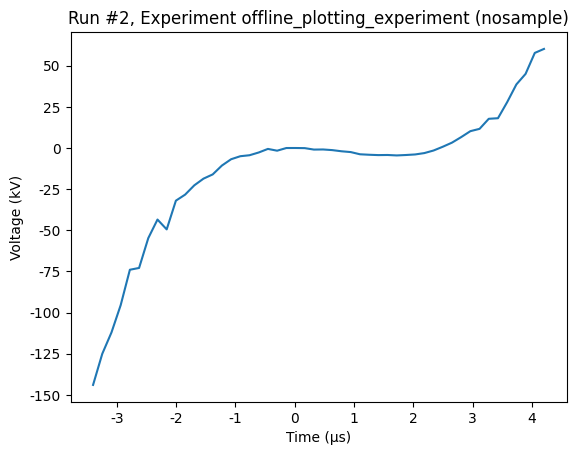

In [8]:
plot_dataset(dataset)

## Two interleaved 1D sweeps

Now we make a run where two parameters are measured as a function of the same parameter.

In [9]:
meas = Measurement(exp=exp)
meas.register_parameter(x)
meas.register_parameter(y, setpoints=[x])
meas.register_parameter(y2, setpoints=[x])

xvals = np.linspace(-5, 5, 250)

with meas.run() as datasaver:

    for xnum in xvals:
        datasaver.add_result((x, xnum),
                             (y, xnum**2))
        datasaver.add_result((x, xnum),
                             (y2, -xnum**2))

dataset = datasaver.dataset

Starting experimental run with id: 3. 


In such a situation, the `plot_dataset` by default creates a new axis for **each** dependent parameter. Sometimes this is not desirable; we'd rather have both plots on the same axis. If this is the case, then, we might pass the same axis twice to the `plot_dataset`.

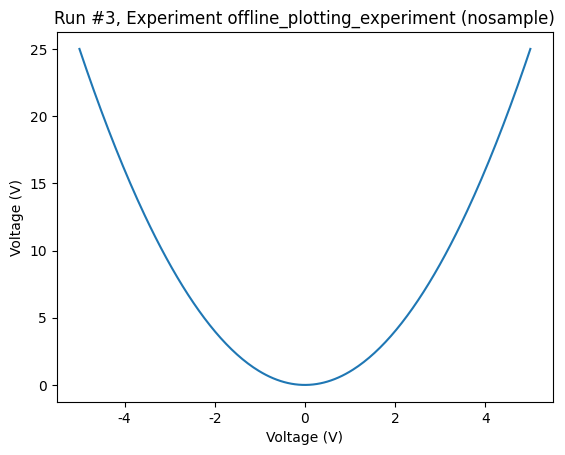

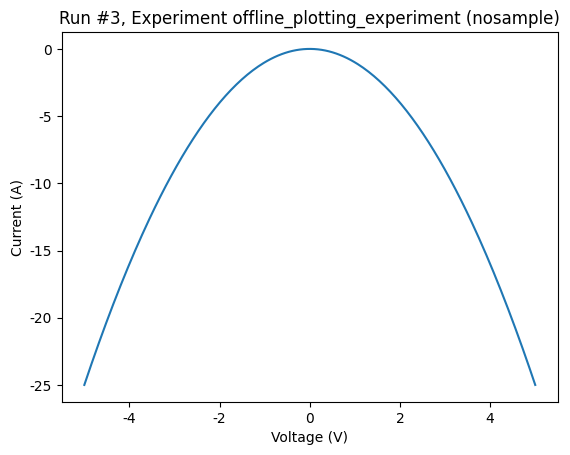

In [10]:
axes, cbaxes = plot_dataset(dataset)

Let's do that now

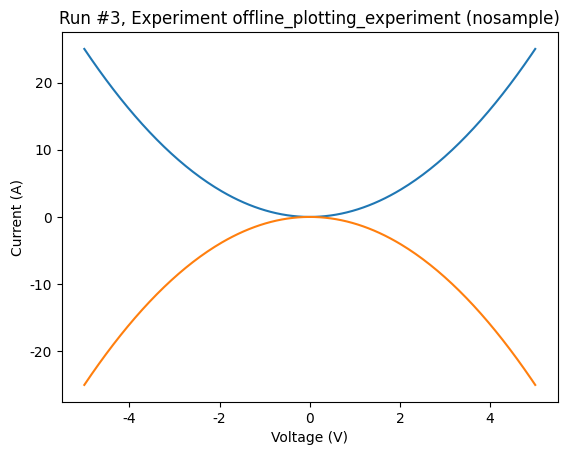

In [11]:
fig, ax = plt.subplots(1)
axes, cbaxes = plot_dataset(dataset, axes=[ax, ax])

## Regular 2D rectangular sweep scan

For 2D plots, a colorbar is usually present. As mentioned above, the `plot_dataset` function returns a colorbar.

In [12]:
meas = Measurement(exp=exp)

meas.register_parameter(x)
meas.register_parameter(t)
meas.register_parameter(z, setpoints=(x, t))

xvals = np.linspace(-4, 5, 50)
tvals = np.linspace(-500, 1500, 25)

with meas.run() as datasaver:
    for xv in xvals:
        for tv in tvals:
            # just some arbitrary semi good looking function
            zv = np.sin(2*np.pi*xv)*np.cos(2*np.pi*0.001*tv) + 0.001*tv
            datasaver.add_result((x, xv), (t, tv), (z, zv))

dataset = datasaver.dataset

Starting experimental run with id: 4. 


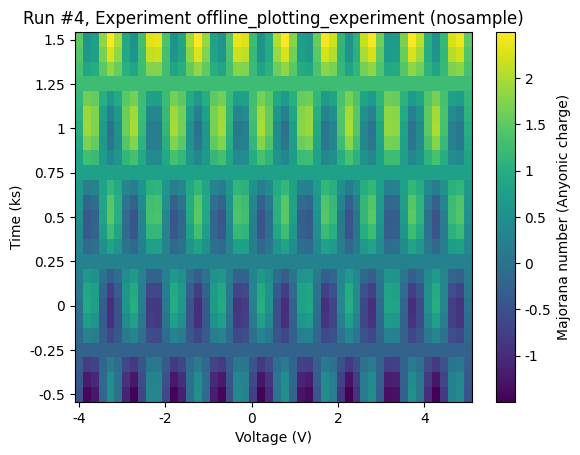

In [13]:
axes, colorbars = plot_dataset(dataset)

A fairly normal situation is that the colorbar was somehow mislabelled. Using the returned colorbar, the label can be overwritten.

In [14]:
colorbar = colorbars[0]
colorbar.set_label('Correct science label')

### Customisations

In addition to tweaking the returned axes and colorbars, it is possible to customise the plot directly via the call to the `plot_dataset`. This is done by the `plot_dataset` via passing on the keyword arguments to the corresponding `matplotlib` function that runs under the hood. 

A few examples:

#### Changing the colormap

Any `matplotlib` colormap can be used. The relevant keyword argument is `cmap`.

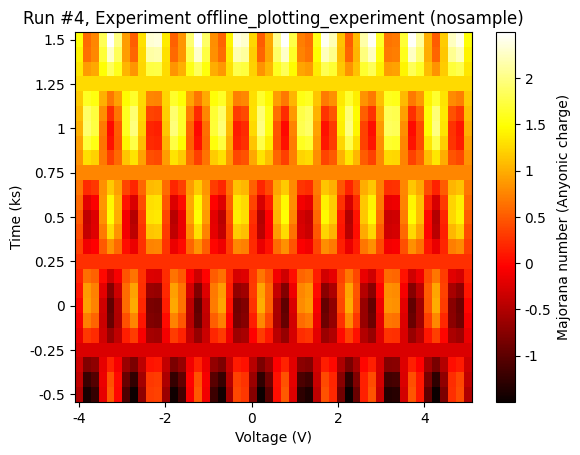

In [15]:
cmap = matplotlib.colormaps.get_cmap("hot")
axes, colorbars = plot_dataset(dataset, cmap=cmap)

#### Setting the colorscale to logarithmic

To set the colorscale to logarithmic, we can use the keyword argument `norm` along with a `matplotlib` `Norm`.

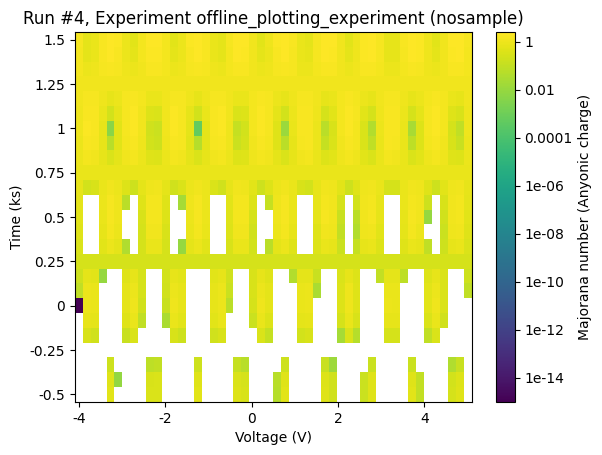

In [16]:
from matplotlib.colors import LogNorm

norm=LogNorm()
axes, colorbars = plot_dataset(dataset, norm=norm)

#### Setting limits on the colorscale

The keyword arguments `vmin` and `vmax` come in handy, if we need to set limits on the colorscale.

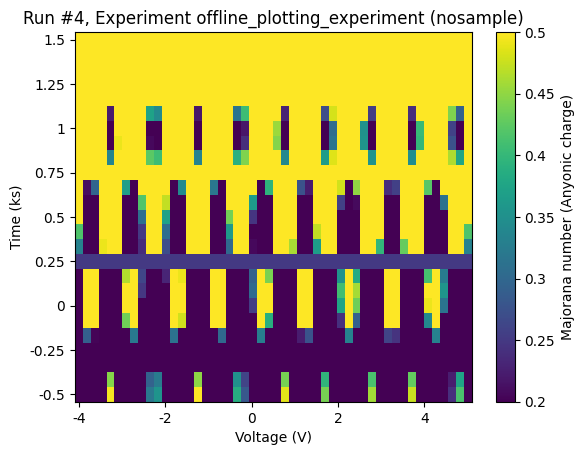

In [17]:
axes, colorbars = plot_dataset(dataset, vmin=0.2, vmax=0.5)

## Warped 2D rectangular sweep scan

A nice feature of the `plot_dataset` is that the grid may be warped; it makes no difference.
Here we warp the x axis of the previous scan to increase the resolution in the right half plane.

In [18]:
xvals = np.linspace(-4, 5, 50) + np.cos(-1/6*np.pi*xvals)
tvals = np.linspace(-500, 1500, 25)

with meas.run() as datasaver:
    for xv in xvals:
        for tv in tvals:
            zv = np.sin(2*np.pi*xv)*np.cos(2*np.pi*0.001*tv) + 0.001*tv
            datasaver.add_result((x, xv), (t, tv), (z, zv))

dataset = datasaver.dataset

Starting experimental run with id: 5. 


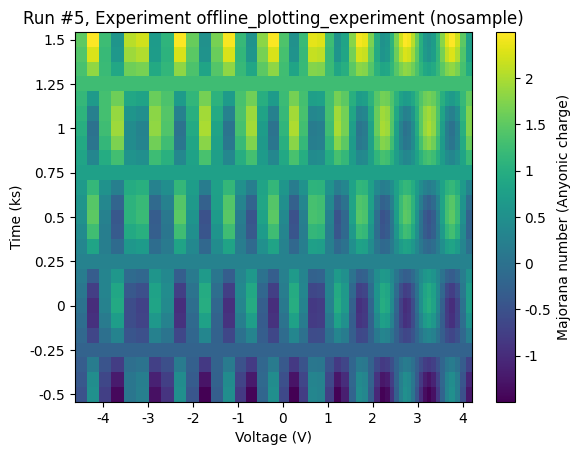

In [19]:
axes, cbaxes = plot_dataset(dataset)

## Interrupted 2D scans (a hole in the cheese)

In case a sweep in interrupted, the entire grid will not be filled out. This is also supported,
in fact, any single rectangular hole is allowed.

In [20]:
xvals = np.linspace(-4, 5, 50) + np.cos(2/9*np.pi*xvals+np.pi/4)
tvals = np.linspace(-500, 1500, 25)

# define two small forbidden range functions


def no_x(xv):
    if xv > 0 and xv < 3:
        return True
    else:
        return False


def no_t(tv):
    if tv > 0 and tv < 450:
        return True
    else:
        return False


with meas.run() as datasaver:
    for xv in xvals:
        for tv in tvals:
            if no_x(xv) and no_t(tv):
                continue
            else:
                zv = np.sin(2*np.pi*xv)*np.cos(2*np.pi*0.001*tv) + 0.001*tv
                datasaver.add_result((x, xv), (t, tv), (z, zv))

dataset = datasaver.dataset

Starting experimental run with id: 6. 


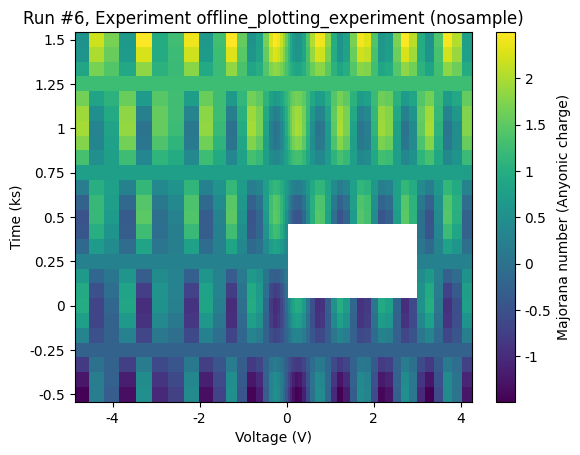

In [21]:
axes, colorbars = plot_dataset(dataset)

## Fancy plotting

As a final example, let us combine several plots in one window.

We first make a little grid of axes.

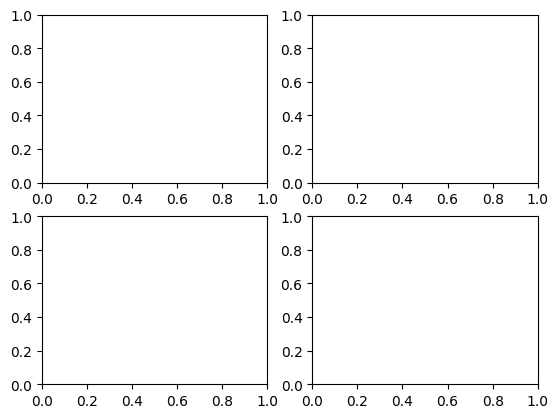

In [22]:
fig, figaxes = plt.subplots(2, 2)

Next, we make some runs (shamelessly copy-pasting from above).

In [23]:
# First run
meas = Measurement(exp=exp)
meas.register_parameter(x)
meas.register_parameter(y, setpoints=(x,))

xvals = np.linspace(-3.4, 4.2, 250)

with meas.run() as datasaver:
    for xnum in xvals:
        noise = np.random.randn()*0.1  # multiplicative noise yeah yeah
        datasaver.add_result((x, xnum),
                             (y, 2*(xnum+noise)**3 - 5*(xnum+noise)**2))

ds1 = datasaver.dataset

# Second run

meas = Measurement(exp=exp)

meas.register_parameter(x)
meas.register_parameter(t)
meas.register_parameter(z, setpoints=(x, t))

xvals = np.linspace(-4, 5, 50)
tvals = np.linspace(-500, 1500, 25)

with meas.run() as datasaver:
    for xv in xvals:
        for tv in tvals:
            # just some arbitrary semi good looking function
            zv = np.sin(2*np.pi*xv)*np.cos(2*np.pi*0.001*tv) + 0.001*tv
            datasaver.add_result((x, xv), (t, tv), (z, zv))

ds2 = datasaver.dataset

Starting experimental run with id: 7. 
Starting experimental run with id: 8. 


And then we put them just where we please.

In [24]:
axes, colorbars = plot_dataset(ds1, figaxes[0, 0])

In [25]:
axes, colorbars = plot_dataset(ds2, figaxes[1, 1], colorbars)

Note that if we want to replot on an axis with a colorbar we probably also want to reuse the colorbar.

In [26]:
axes, colorbars = plot_dataset(ds2, figaxes[1, 1], colorbars)

In [27]:
fig.tight_layout()

## Rasterizing

By default `matplotlib` renders each individual data point as a separate square in 2D plots when storing in a vector format (pdf, svg). This is not a problem for small data sets, but the time needed to generate a pdf increases rapidly with the number of data points. Therefore, the `plot_dataset` will automatically raster the data (lines, ticks and labels are still stored as text) if more than 5000 data points are plotted. The particular value of the rasterization threshold can be set in the `qcodesrc.json` config file.

Alternatively the `rasterized` keyword can be passed to the `plot_dataset` function.

In [28]:
meas = Measurement(exp=exp)

meas.register_parameter(x)
meas.register_parameter(t)
meas.register_parameter(z, setpoints=(x, t))

xvals = np.linspace(-4, 5, 100)
tvals = np.linspace(-500, 1500, 500)

with meas.run() as datasaver:
    for xv in xvals:
        for tv in tvals:
            # just some arbitrary semi good looking function
            zv = np.sin(2*np.pi*xv)*np.cos(2*np.pi*0.001*tv) + 0.001*tv
            datasaver.add_result((x, xv), (t, tv), (z, zv))

dataset = datasaver.dataset

Starting experimental run with id: 9. 


To get a feeling for the time difference between rasterzing and not, we time the two approaches here.

CPU times: user 263 ms, sys: 317 ms, total: 580 ms
Wall time: 270 ms


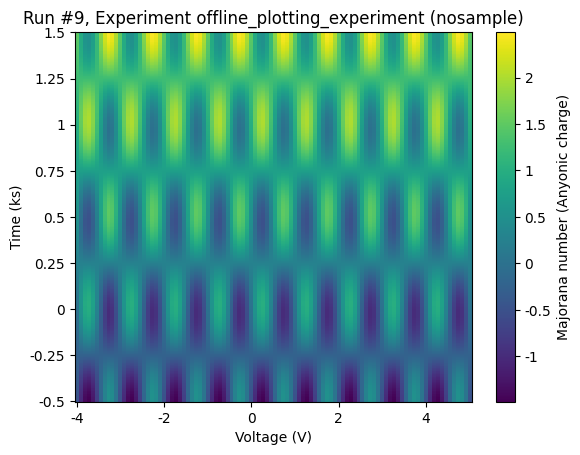

In [29]:
%%time
axeslist, _ = plot_dataset(dataset)
axeslist[0].figure.savefig(f'test_plot_dataset_{dataid}.pdf')

CPU times: user 3.7 s, sys: 258 ms, total: 3.96 s
Wall time: 3.67 s


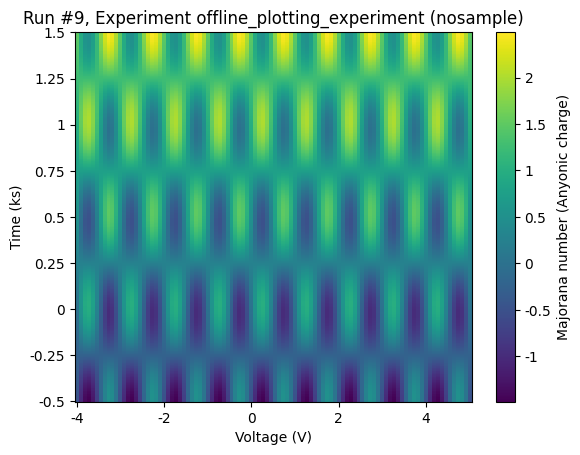

In [30]:
%%time
axeslist, _ = plot_dataset(dataset, rasterized=False)
axeslist[0].figure.savefig(f'test_plot_dataset_{dataid}.pdf')